In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve,
    accuracy_score,
    classification_report,
    roc_auc_score,
)

from alibi.explainers import AnchorTabular
import shap
from lime import lime_tabular

import warnings

warnings.filterwarnings("ignore")


/Users/gabrielgraells/workspace/university/XAI_project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# COMPAS EDA

In [2]:
compas_raw = pd.read_csv("data/compas_raw.csv")
compas_raw.head()

id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custody  out_custody  priors_count.1  \
0           Low        2013-08-14  2014-07-07   2014-07-14               0   
1           Low        2013-01-27  2013-01-26   2013-02-05               0   
2           Low        2013-04-14  2013-06-16   2013-06-16               4   
3        Medium        2013-01-13         NaN          NaN               1   
4           Low        2013-03-26         NaN          NaN               2   

  start   end event two_year_recid  
0     0   327     0              0  
1     9   159     1              1  
2     0    63     0              1  
3     0  1174     0              0  
4     0  1102     0              0  

[5 rows x 53 columns]

## Columns

| Column Name               | Description |
|---------------------------|-------------|
| `id`                      | A unique identifier for each individual in the dataset. |
| `name`                    | The name of the individual (usually anonymized). |
| `first`                   | The first name of the individual. |
| `last`                    | The last name of the individual. |
| `compas_screening_date`   | The date when the COMPAS assessment was conducted. |
| `dob`                     | The date of birth of the individual. |
| `age`                     | The age of the individual at the time of assessment. |
| `age_cat`                 | The age category of the individual (e.g., `<25`, `25-45`, `>45`). |
| `sex`                     | The gender of the individual (`Male` or `Female`). |
| `race`                    | The race of the individual (e.g., `African-American`, `Caucasian`, `Hispanic`, etc.). |
| `juv_fel_count`           | The number of juvenile felony offenses committed by the individual. |
| `juv_misd_count`          | The number of juvenile misdemeanor offenses committed by the individual. |
| `juv_other_count`         | The number of other juvenile offenses (not classified as felony or misdemeanor). |
| `priors_count`            | The total number of prior criminal offenses before the current charge. |
| `days_b_screening_arrest` | The number of days between the arrest and the COMPAS screening date. |
| `c_charge_degree`         | The severity of the current charge (`M` for Misdemeanor, `F` for Felony). |
| `c_charge_desc`           | A description of the current charge (e.g., `Grand Theft`, `Drug Possession`). |
| `is_recid`                | Whether the individual reoffended (`1` for Yes, `0` for No`). |
| `r_charge_degree`         | The severity of the charge if the individual reoffended (`M` for Misdemeanor, `F` for Felony). |
| `r_charge_desc`           | The description of the reoffense charge (if applicable). |
| `two_year_recid`          | Whether the individual was arrested again within two years of the assessment (`1` for Yes, `0` for No`). |
| `decile_score`            | The COMPAS risk score (ranges from `1` to `10`, where higher scores indicate a higher likelihood of recidivism). |
| `score_text`              | A categorical version of the COMPAS score (`Low`, `Medium`, `High`). |
| `violent_recid`           | Whether the individual committed a violent reoffense (`1` for Yes, `0` for No`). |
| `v_decile_score`          | The COMPAS risk score for violent recidivism. |
| `v_score_text`            | A categorical version of the violent recidivism risk score (`Low`, `Medium`, `High`). |
| `r_days_from_arrest`      | The number of days from the first arrest to the reoffense (if applicable). |
| `type_of_assessment`      | The type of COMPAS assessment conducted (e.g., `Risk of Recidivism`, `Risk of Violence`). |
| `screening_date`          | The date of the COMPAS assessment. |
| `in_custody`             | The date when the individual was taken into custody. |
| `out_custody`            | The date when the individual was released from custody. |
| `start`                   | The start date of the risk period considered. |
| `end`                     | The end date of the risk period considered. |


In [3]:
# Selected columns, removing inferences columns
cols_types = {
    "first": "category",
    "last": "category",
    "age": "int64",
    "sex": "category",
    "race": "category",
    "juv_fel_count": "int64",
    "juv_misd_count": "int64",
    "juv_other_count": "int64",
    "priors_count": "int64",
    "c_charge_degree": "category",
    "is_recid": "int64",
}

cols = list(cols_types.keys())

label = "is_recid"

exclude = ["first", "last", "age"]
features = [c for c in cols if c != label and c not in exclude]

# Change col types
compas = compas_raw[cols].astype(cols_types)

compas.head()


first         last  age   sex              race  juv_fel_count  \
0  miguel    hernandez   69  Male             Other              0   
1   kevon        dixon   34  Male  African-American              0   
2      ed        philo   24  Male  African-American              0   
3   marcu        brown   23  Male  African-American              0   
4  bouthy  pierrelouis   43  Male             Other              0   

   juv_misd_count  juv_other_count  priors_count c_charge_degree  is_recid  
0               0                0             0               F         0  
1               0                0             0               F         1  
2               0                1             4               F         1  
3               1                0             1               F         0  
4               0                0             2               F         0

## Data Cleaning

In [4]:
# Nan values
compas.isna().sum()

first              0
last               0
age                0
sex                0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
is_recid           0
dtype: int64

# Feature Engineering

In [5]:
# Bucketize age in 5 years equidistant intervals
features += ["age_bucket"]
cols += ["age_bucket"]
compas.loc[:, "age_bucket"] = pd.cut(compas["age"], bins=range(0, 100, 5), right=False)
compas["age_bucket"] = compas["age_bucket"].astype("category")

# EDA

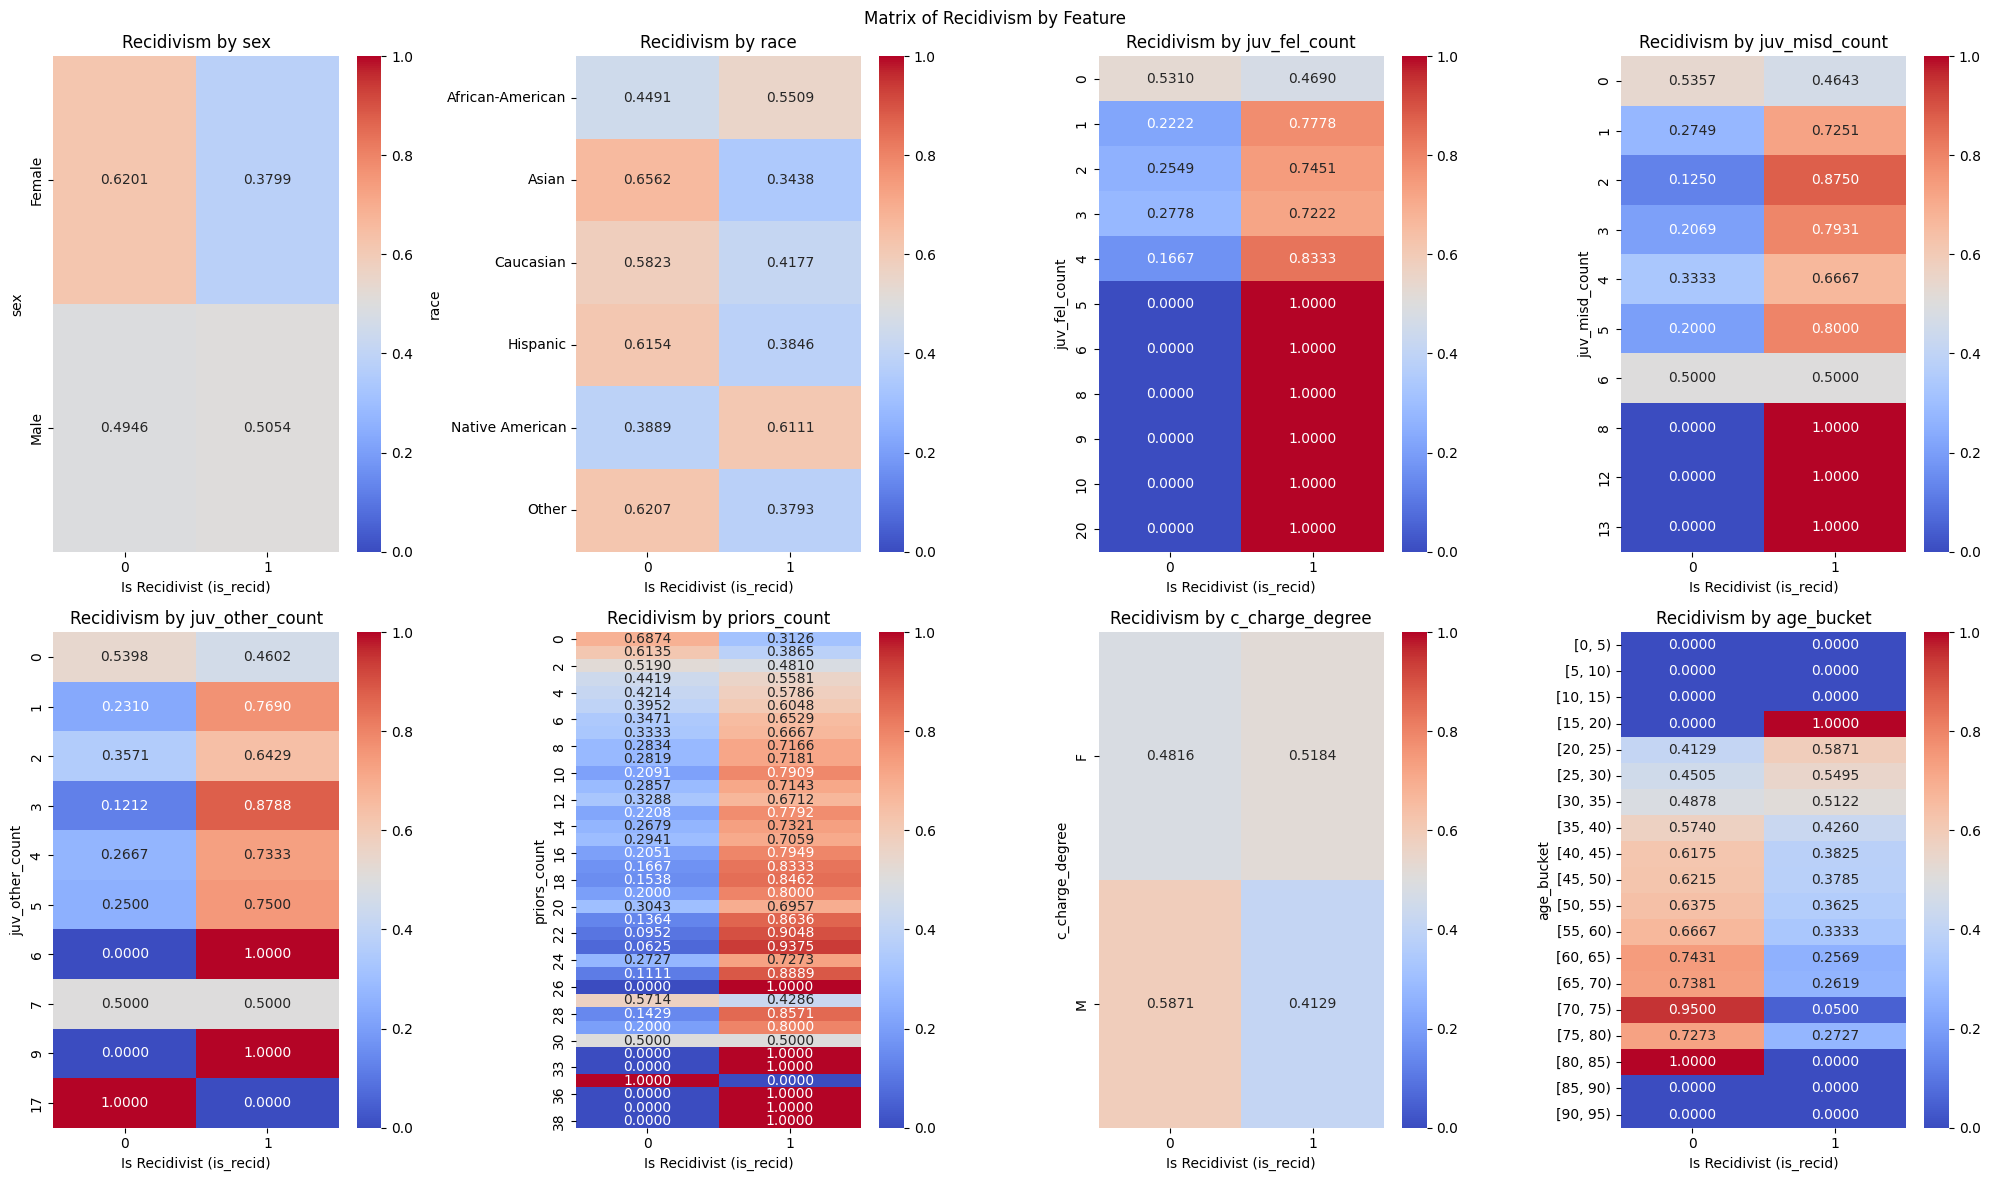

In [6]:
def calculate_recid_matrix(compas: pd.DataFrame, col: str):
    return compas.groupby([col])["is_recid"].value_counts(normalize=True).unstack().fillna(0)

def plot_recid_matrix(ax, recid_matrix, col):
    # Set vmin and vmax to fix the color legend range from 0 to 1
    sns.heatmap(data=recid_matrix, annot=True, cmap="coolwarm", fmt=".4f",
                vmin=0, vmax=1, ax=ax)
    
    # Labels and title
    ax.set_ylabel(col)  # Dynamically set column name
    ax.set_xlabel("Is Recidivist (is_recid)")
    ax.set_title(f"Recidivism by {col}")

# Assume 'features' is a list of column names and 'compas' is your DataFrame
nrows = 2
ncols = (len(features) + 1) // nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))

fig.suptitle("Matrix of Recidivism by Feature")

for feature, ax in zip(features, axs.flat):
    recid_matrix = calculate_recid_matrix(compas, feature)
    plot_recid_matrix(ax, recid_matrix, feature)

plt.tight_layout()
plt.show()

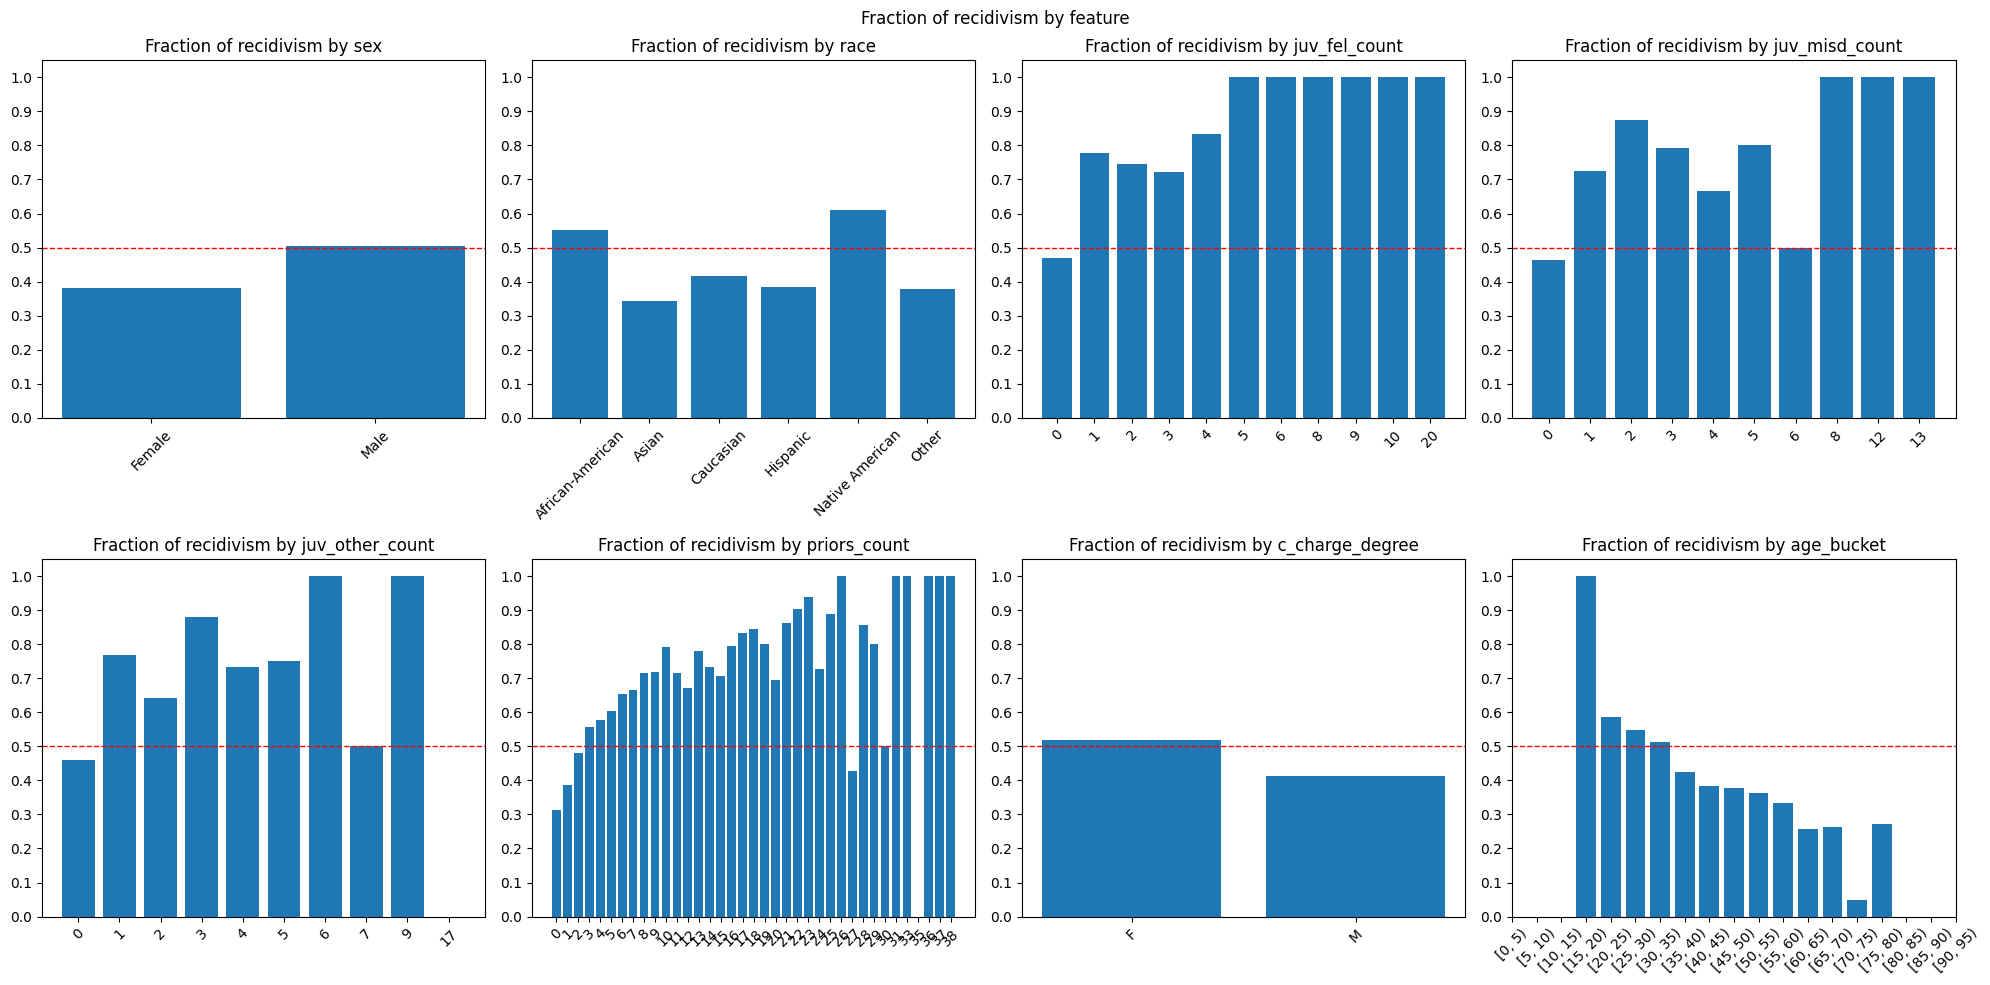

In [7]:
def calculate_recid_fraction(compas: pd.DataFrame, col: str):
    return compas.groupby(col)["is_recid"].mean()


def plot_fraction_recid(ax, fraction_recid, col):
    ax.set_title(f"Fraction of recidivism by {col}")
    ax.bar(fraction_recid.index.astype(str), fraction_recid.values)
    ax.set_xticks(range(len(fraction_recid.index)))
    ax.set_xticklabels(fraction_recid.index.astype(str), rotation=45)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.axhline(y=0.5, color="red", linestyle="dashed", linewidth=1)
    ax.set_ylim(0, 1.05)  # Apply consistent y limits


nrows = 2
ncols = (len(features) + 1) // nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))

fig.suptitle("Fraction of recidivism by feature")

for feature, ax in zip(features, axs.flat):
    fraction_recid = calculate_recid_fraction(compas, feature)
    plot_fraction_recid(ax, fraction_recid, feature)

plt.tight_layout()
plt.show()


# Gradient Boosting Classifier

In [8]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, recall, and F1-score
    print("Classification Report:\n", classification_report(y, y_pred))
    
    y_prob = model.predict_proba(X)[:, 1]
    auc_roc = roc_auc_score(y, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")

    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr, label="LightGBM (AUC = {:.4f})".format(auc_roc))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # Plot a single decision tree from the trained model
    tree_index = 43  # Select the tree
    graph = lgb.create_tree_digraph(
        model,
        tree_index=tree_index,
        show_info=["split_gain", "internal_value", "leaf_count"],
    )

    # Display the tree graph
    display(graph)

In [9]:

# Assume compas, features, and label are defined earlier.
# Copy the data to avoid modifying the original DataFrame.
X = compas[features].copy()
y = compas[label]

# Identify categorical columns.
# (If your categorical columns are stored as strings, convert them to 'category' first.)
categorical_cols = X.select_dtypes(include=["category", "object"]).columns.tolist()

# Convert categorical columns to numeric codes.
for col in categorical_cols:
    # If the column isn't already a 'category', convert it.
    if not pd.api.types.is_categorical_dtype(X[col]):
        X[col] = X[col].astype("category")
    # Replace with integer codes.
    X[col] = X[col].cat.codes

# Now, X should only contain numeric types (int, float, or bool).
# You can either specify the categorical features (as their column names) or omit them.
# Note: Even though the columns are now numeric, you may still inform LightGBM that they represent categorical data.
#       LightGBM will treat them as categorical if you pass their indices or names in categorical_feature.
model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_leaves=14,
    learning_rate=0.05,
    n_estimators=100,
)

# Option 1: Specify categorical_feature if you want LightGBM to perform categorical splitting.
# Option 2: Leave it out if you don't need special categorical handling.
model.fit(X, y, categorical_feature=categorical_cols, eval_set=[(X, y)])


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 3471, number of negative: 3743
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 7214, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481148 -> initscore=-0.075445
[LightGBM] [Info] Start training from score -0.075445


LGBMClassifier(learning_rate=0.05, num_leaves=14, objective='binary')

Accuracy: 0.6869
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.77      0.72      3743
           1       0.70      0.60      0.65      3471

    accuracy                           0.69      7214
   macro avg       0.69      0.68      0.68      7214
weighted avg       0.69      0.69      0.68      7214

AUC-ROC Score: 0.7534


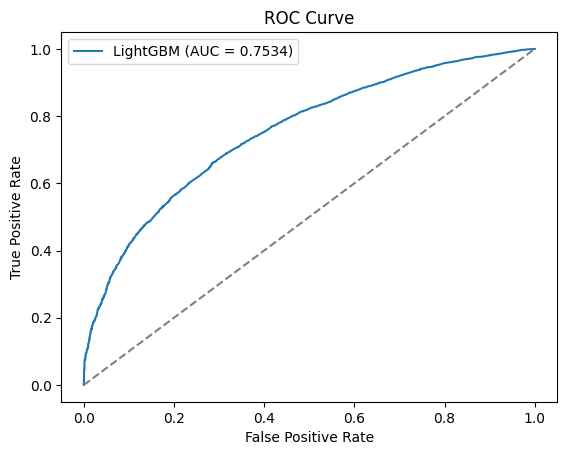

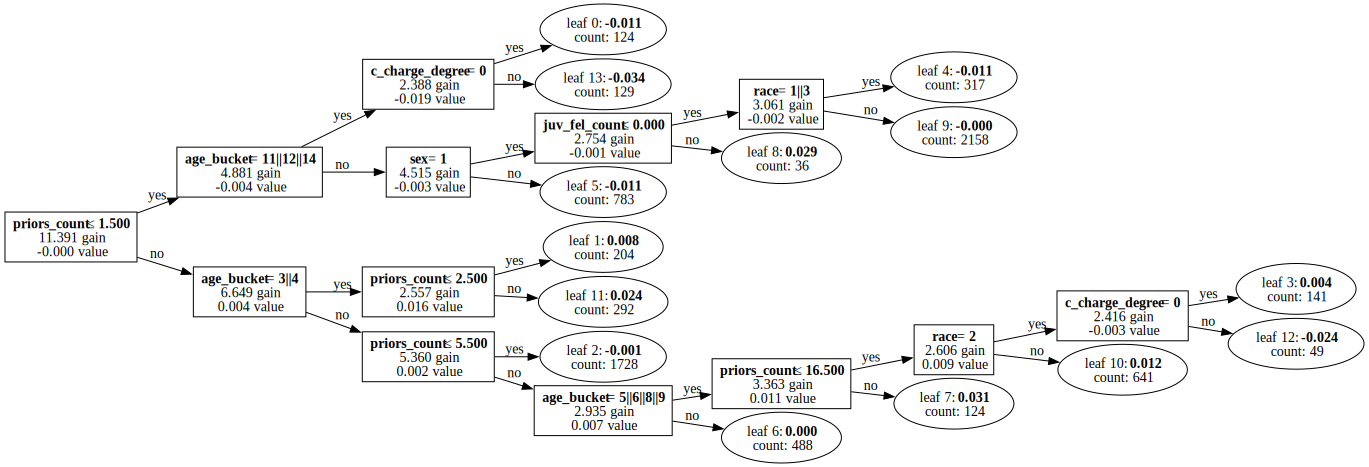

In [10]:
evaluate(model, X, y)

# LIME

In [11]:
categorical_cols

['sex', 'race', 'c_charge_degree', 'age_bucket']

In [12]:
y_pred = model.predict(X)


for col in categorical_cols:
    X[col] = X[col].astype("category")

X_numeric = X.copy()
for col in categorical_cols:
    X_numeric[col] = X_numeric[col].astype("category").cat.codes

categorical_feature_indices = [
    X_numeric.columns.get_loc(col) for col in categorical_cols
]
categorical_names = {
    X_numeric.columns.get_loc(col): list(X[col].cat.categories)
    for col in categorical_cols
}

class_names = ["No Recidivism", "Recidivism"]
lime = lime_tabular.LimeTabularExplainer(
    training_data=X_numeric.to_numpy(),
    mode="classification",
    feature_names=features,
    categorical_features=categorical_feature_indices,
    categorical_names=categorical_names,
    class_names=class_names,
)


In [13]:
tests_idxs = np.random.randint(0, len(X), 5)

for test_idx in tests_idxs:
    instance = X.iloc[test_idx]
    print('Model prediction: ', class_names[y_pred[test_idx]])
    print('True label: ', class_names[y.iloc[test_idx]])
    exp = lime.explain_instance(
        data_row=X_numeric.iloc[test_idx],
        predict_fn=model.predict_proba
    )
    exp.show_in_notebook(show_table=True)


Model prediction:  No Recidivism
True label:  No Recidivism


Model prediction:  Recidivism
True label:  No Recidivism


Model prediction:  Recidivism
True label:  Recidivism


Model prediction:  No Recidivism
True label:  No Recidivism


Model prediction:  Recidivism
True label:  Recidivism


# Anchor

In [21]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X[col] = encoders[col].fit_transform(X[col])

anchor = AnchorTabular(
    model.predict,
    features,
    seed=1,
)

anchor.fit(train_data=X.to_numpy(), disc_perc=[25, 50, 75])

random_idx = np.random.randint(0, len(X), 5)

for idx in random_idx:
    explanation = anchor.explain(X.to_numpy()[idx], threshold=0.95)
    print(
        f"Model prediction: { class_names[y_pred[idx]]} -- Anchor Explanation: {explanation.anchor} -- Precision: {explanation.precision}"
    )


Model prediction: No Recidivism -- Anchor Explanation: ['priors_count <= 0.00', 'race > 0.00'] -- Precision: 0.964968152866242
Model prediction: No Recidivism -- Anchor Explanation: ['priors_count <= 0.00', 'age_bucket > 6.00'] -- Precision: 1.0
Model prediction: Recidivism -- Anchor Explanation: ['priors_count > 5.00'] -- Precision: 0.9672897196261683
Model prediction: No Recidivism -- Anchor Explanation: ['priors_count <= 0.00', 'age_bucket > 6.00'] -- Precision: 1.0
Model prediction: No Recidivism -- Anchor Explanation: ['priors_count <= 0.00', 'age_bucket > 6.00'] -- Precision: 1.0


# SHAP

In [15]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X.to_numpy())

test_idx = tests_idxs[0]

test_shap_values = shap_values[test_idx]

shap.initjs()
shap.force_plot(
    shap_explainer.expected_value,
    test_shap_values,
    features=X.iloc[test_idx],
    feature_names=features,
)


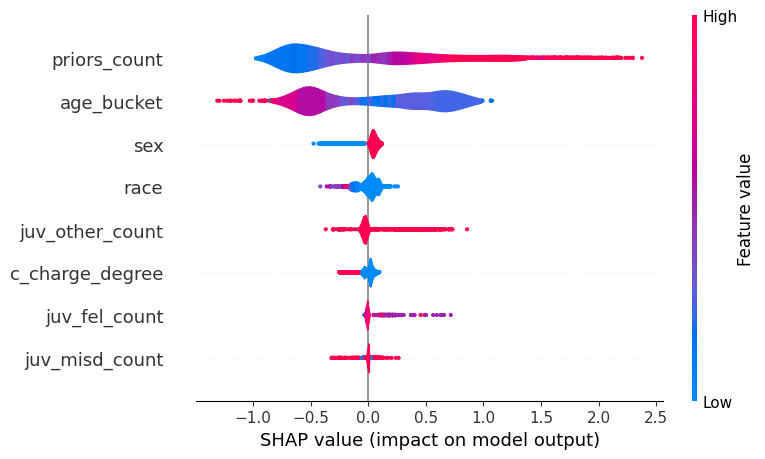

In [16]:
class_index = 3
shap.summary_plot(shap_values, X, plot_type="violin")

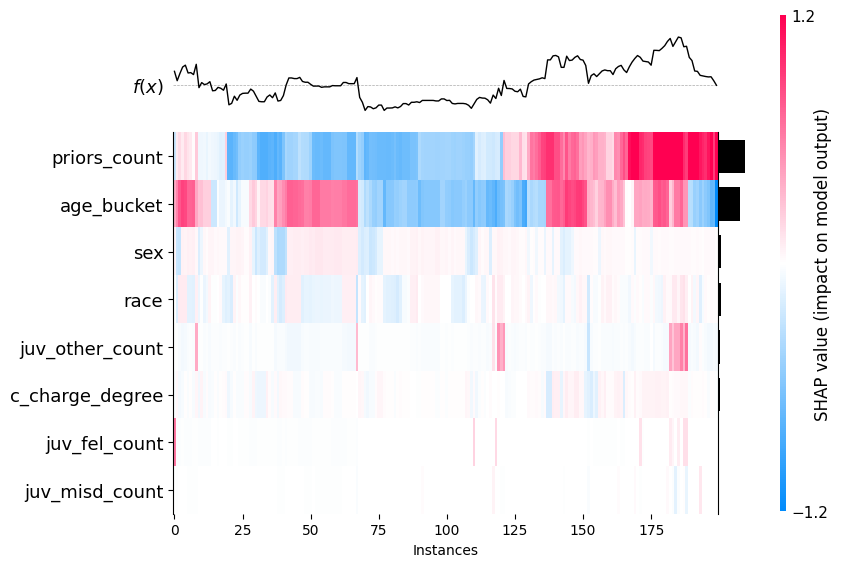

<Axes: xlabel='Instances'>

In [17]:
X_sample_np = X.iloc[:200].to_numpy()
explanation = shap_explainer(X_sample_np)
explanation.feature_names = X.columns.tolist()

shap.plots.heatmap(explanation)


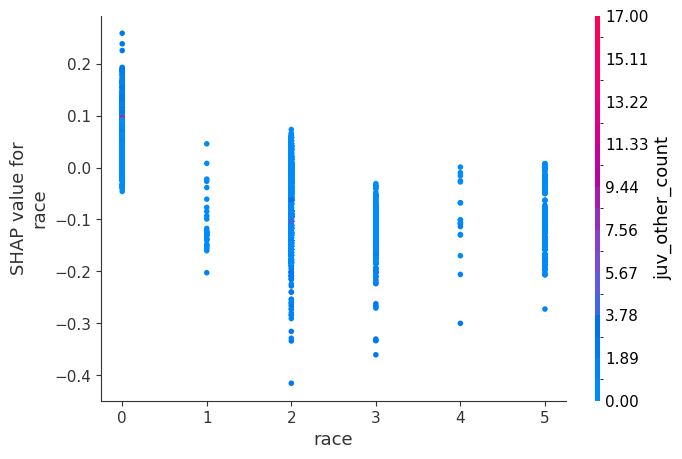

In [18]:
shap.dependence_plot("race", shap_values, X)